In [4]:
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
import sys
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.2


In [5]:
class PDENet:
    # Init
    def __init__(self, xb, yb, ub, x, y, layers):
        
        # Xb = np.concatenate([xb, yb, ub], 1)
        # X = np.concatenate([x, y], 1)
        self.dim = 2
        
        self.xb = xb
        self.yb = yb
        self.ub = ub
        self.x = x
        self.y = y
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.init_NN(layers)
        
        # Initialize parameters
        # self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        # self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.xyb_tf = tf.placeholder(tf.float32, shape=[None, 2, 1])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xy_tf = tf.placeholder(tf.float32, shape=[None, 2, 1])

        self.ub_pred, _ , _ = self.net_u(self.xyb_tf)
        _ , self.f_u_pred= self.net_f_u(self.xy_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.ub_tf - self.ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        self.lossHistogram = []
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        # self.saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def init_NN(self, layers):
        dim = self.dim
        weights = []
        biases = []
        num_layers = len(layers)
        W = self.xavier_init(size=[layers[0], dim])
        b = tf.Variable(tf.zeros([layers[0],1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b)
        for l in range(1,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l]])
            b = tf.Variable(tf.zeros([layers[l],1], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)  
        W = self.xavier_init(size=[1, layers[-1]])
        b = tf.Variable(tf.zeros([1,1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b) 
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def net_nn(self, X, weights, biases):
        num_layers = len(self.layers)
        S = X
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            S = tf.tanh(tf.add(tf.matmul(W, S), b))
        W = weights[-1]
        b = biases[-1]
        S = tf.add(tf.matmul(W, S), b)
        return S

    def net_u(self, xy):
        u = self.net_nn(xy, self.weights, self.biases)
        u = u[:,0]
        u_x = tf.gradients(u, xy)[0][:,0]
        u_y = tf.gradients(u, xy)[0][:,1]
        return u, u_x, u_y
        
    def net_f_u(self, xy):
        u, u_x, u_y = self.net_u(xy)

        u_xx = tf.gradients(u_x, xy)[0][:,0]
        u_yy = tf.gradients(u_y, xy)[0][:,1]
        f_u = (-1.0)*(u_xx + u_yy) - 2.0*np.pi*np.pi*tf.math.sin(np.pi*xy[:,0])*tf.math.sin(np.pi*xy[:,1])
        print(f_u)
        
        return u, f_u
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        self.lossHistogram.append(loss)
      
    def train(self, nIter): 

        tf_dict = {self.xyb_tf: np.concatenate([self.xb, self.yb], 1), self.ub_tf: self.ub,
                   self.xy_tf: np.concatenate([self.x, self.y], 1)}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            # if it % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            self.lossHistogram.append(loss_value)
            start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        
        # self.saver.save(self.sess, 'my-model.ckpt')
    
    def predict(self, x, y):
        
        tf_dict = {self.xyb_tf: np.concatenate([x, y], 1)}
        
        u = self.sess.run(self.ub_pred, tf_dict)

        # tf_dict = {self.x_tf: x, self.y_tf: y}
        
        # f_u = self.sess.run(self.f_u_pred, tf_dict)
        
        return u

In [6]:
class sampling_from_rectangle:
	def __init__(self, x_range, y_range):
		self.x_range = x_range
		self.y_range = y_range

	def interior_samples(self, batchsize):
		int_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
		int_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)

		return int_draw_x, int_draw_y

	def boundary_samples(self, batchsize):
		a = self.x_range[1]-self.x_range[0]
		b = self.y_range[1]-self.y_range[0]

		draw_perimeter = np.random.uniform(0, 2*(a + b), batchsize)

		draw = []

		for i in draw_perimeter:
			if i < a:
				draw.append([i+ self.x_range[0], self.y_range[0]])
			elif a <= i and i < a+b:
				draw.append([self.x_range[1], (i-a) + self.y_range[0]])
			elif a+b <= i and i < 2*a+b:
				draw.append([self.x_range[1] - (i-(a+b)), self.y_range[1]])
			elif 2*a+b <= i and i<= 2*a+2*b:
				draw.append([self.x_range[0], self.y_range[1] - (i-(2*a+b))])

		return np.array(draw)[:, 0], np.array(draw)[:, 1]

In [ ]:
sampler = sampling_from_rectangle([0.0, 1.0], [0.0, 1.0])
N = 500;
filename = 'data_'

with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y = sampler.boundary_samples(N)
    int_draw_x, int_draw_y = sampler.interior_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], bou_draw_x[i], bou_draw_y[i], 0.0])

dataset = np.genfromtxt('data_500.csv', delimiter=',')
print(dataset)

[[0.93654143 0.75526375 0.46605683 0.         0.        ]
 [0.85086658 0.70998406 0.14026683 1.         0.        ]
 [0.82433124 0.32229588 0.         0.90319176 0.        ]
 ...
 [0.13525493 0.45658654 1.         0.25739073 0.        ]
 [0.14991684 0.18672873 1.         0.1491583  0.        ]
 [0.95823019 0.36411965 0.08488416 0.         0.        ]]


In [7]:
def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    for row in data:
        if (row[0] == 0. or row[1] == 0. or row[0] == 1. or row[1] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(0.0)
        else:
            x.append(row[0])
            y.append(row[1])
    return np.array(x), np.array(y), np.array(xb), np.array(yb), np.array(ub)

In [32]:
dataset = np.genfromtxt('modified_triangle_data.txt', delimiter=',')
x,y,xb,yb,ub = splitData(dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
layers = [64, 64, 64]



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Tensor("sub_11:0", shape=(?, 1), dtype=float32)
Loss: 9.656e+01
Loss: 8.950e+01
Loss: 7.224e+01
Loss: 3.891e+01
Loss: 5.651e+01
Loss: 3.535e+01
Loss: 3.800e+01
Loss: 2.867e+01
Loss: 2.780e+01
Loss: 2.671e+01
Loss: 2.475e+01
Loss: 2.219e+01
Loss: 2.069e+01
Loss: 1.688e+01
Loss: 1.524e+01
Loss: 1.350e+01
Loss: 1.020e+01
Loss: 9.536e+00
Loss: 9.241e+00
Loss: 8.926e+00
Loss: 8.008e+00
Loss: 7.317e+00
Loss: 6.528e+00
Loss: 6.840e+00
Loss: 6.135e+00
Loss: 5.890e+00
Loss: 5.536e+00
Loss: 5.340e+00
Loss: 4.974e+00
Loss: 4.433e+00
Loss: 4.054e+00
Loss: 3.856e+00
Loss: 3.745e+00
Loss: 3.591e+00
Loss: 3.350e+00
Loss: 3.129e+00
Loss: 2.936e+00
Loss: 2.811e+00
Loss: 2.743e+00
Loss: 2.681e+00
Loss: 2.573e+00
Loss: 2.440e+00
Loss: 2.259e+00
Loss: 2.038e+00
Loss: 1.738e+00
Loss: 1.688e+00
Loss: 1.577e+00
Loss: 1.537e+00
Loss: 1.507e+00
Loss: 1.464e+00
Loss: 1.419e+00
Loss: 1.375e+00
Loss: 1.358e+00
Loss: 1.493e

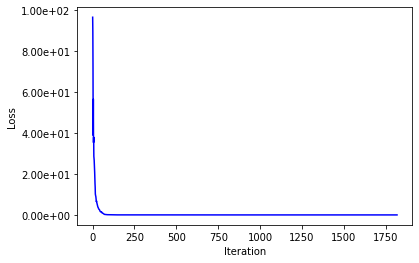

In [33]:
model = PDENet(xb, yb, ub, x, y, layers)
start_time = time.time()                
model.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i+1 for i in range(epochs)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_epochs,losses, color = 'blue')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')
plt.show()

a_file = open("Loss11.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

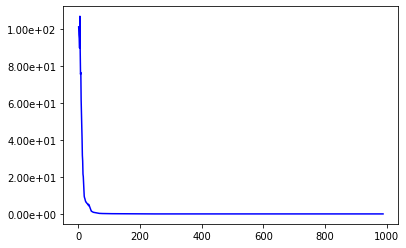

In [ ]:
import matplotlib.ticker as mtick
losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i + 1 for i in range(epochs)]


# plt.plot(x_epochs, losses, color = 'blue')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_epochs,losses, color = 'blue')

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

plt.show()

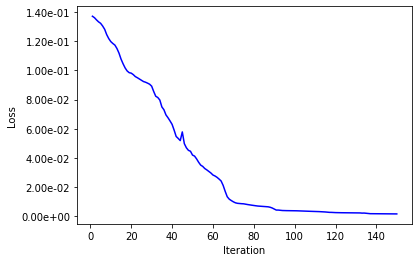

In [ ]:
losses = np.array(model.lossHistogram[100:250])
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i+1 for i in range(epochs)]


# plt.plot(x_epochs, losses, color = 'blue')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_epochs,losses, color = 'blue')

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')

plt.show()

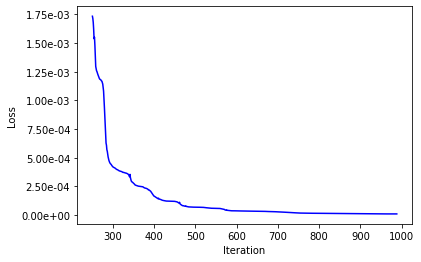

In [ ]:
losses = np.array(model.lossHistogram[250:])
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [250+ i+1 for i in range(epochs)]


# plt.plot(x_epochs, losses, color = 'blue')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_epochs,losses, color = 'blue')

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')

plt.show()

In [ ]:
len(model.lossHistogram)

1876

In [ ]:
model.lossHistogram

In [ ]:
x_epochs[0]

301

In [ ]:
dataset = np.genfromtxt('Loss11.txt', delimiter=',')
dataset.size

988

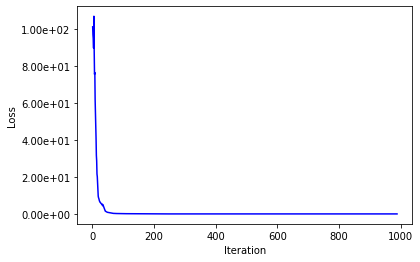

In [ ]:
losses = np.array(dataset)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [ i+1 for i in range(epochs)]


# plt.plot(x_epochs, losses, color = 'blue')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_epochs,losses, color = 'blue')

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')

plt.show()

In [18]:
a_file = open("Loss11.txt", "w")
for row in np.array(model.lossHistogram).reshape(len(model.lossHistogram), 1):
    np.savetxt(a_file, row)
a_file.close()

In [34]:
def exact_solution(x, y):
    u = tf.math.sin(np.pi*x)*tf.math.sin(np.pi*y)
    return u

In [ ]:
datasetTest = np.genfromtxt('test_data.txt', delimiter=',')
x,y,xb,yb,ub = splitData(datasetTest)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
ub = ub.reshape((ub.size, 1))


In [35]:
dataset = np.genfromtxt('data_500.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
xb = dataset[:,2]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,3]
yb = yb.reshape((yb.size, 1, 1))
ub = dataset[:,4]
ub = ub.reshape((ub.size, 1))


In [36]:
# ub_e = exact_solution(xb, yb)
u_e = exact_solution(x, y)
u_e = tf.reshape(u_e, [x.size, 1])

In [37]:
u_pred = model.predict(x, y)
ub_pred = model.predict(xb, yb)

In [ ]:
LossL2_u = tf.reduce_mean(tf.square(u_pred - u_e))
with tf.Session() as sess:
    result = LossL2_u.eval()

    print(result) 

    print(type(result))

8.921680083575608e-07
<class 'numpy.float64'>


In [ ]:
LossL2_u= tf.math.sqrt(LossL2_u)
with tf.Session() as sess:
    result = LossL2_u.eval()

    print(result) 

    print(type(result))

0.000322340128893508
<class 'numpy.float64'>


In [38]:
LossL2 = tf.reduce_mean(tf.square(u_pred - u_e)) + tf.reduce_mean(tf.square(ub_pred - ub))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

2.4459865052591303e-06
<class 'numpy.float64'>


In [39]:
LossL2= tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.0015639649948957074
<class 'numpy.float64'>


In [ ]:
newModel = PDENet(xb, yb, ub, x, y, layers)

In [ ]:
tf.reset_default_graph()
newModel.saver.restore(newModel.sess, 'my-model.ckpt')